In [1]:
from datascience import *
%matplotlib inline
path_data = '../../data/'
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
import numpy as np

### The Bootstrap ###
A data scientist is using the data in a random sample to estimate an unknown parameter. She uses the sample to calculate the value of a statistic that she will use as her estimate. 

Once she has calculated the observed value of her statistic, she could just present it as her estimate and go on her merry way. But she's a data scientist. She knows that her random sample is just one of numerous possible random samples, and thus her estimate is just one of numerous plausible estimates. 

By how much could those estimates vary? To answer this, it appears as though she needs to draw another sample from the population, and compute a new estimate based on the new sample. But she doesn't have the resources to go back to the population and draw another sample.

It looks as though the data scientist is stuck.

Fortunately, a brilliant idea called *the bootstrap* can help her out. Since it is not feasible to generate new samples from the population, the bootstrap generates new random samples by a method called *resampling*: the new samples are drawn at random *from the original sample*.

In this section, we will see how and why the bootstrap works. In the rest of the chapter, we will use the bootstrap for inference.



### Employee Compensation in the City of San Francisco ###
[SF OpenData](https://data.sfgov.org) is a website where the City and County of San Francisco make some of their data publicly available. One of the data sets contains compensation data for employees of the City. These include medical professionals at City-run hospitals, police officers, fire fighters, transportation workers, elected officials, and all other employees of the City. 

Compensation data for the calendar year 2015 are in the table `sf2015`.

In [2]:
sf2015 = Table.read_table(path_data + 'san_francisco_2015.csv')

In [3]:
sf2015

Year Type,Year,Organization Group Code,Organization Group,Department Code,Department,Union Code,Union,Job Family Code,Job Family,Job Code,Job,Employee Identifier,Salaries,Overtime,Other Salaries,Total Salary,Retirement,Health/Dental,Other Benefits,Total Benefits,Total Compensation
Calendar,2015,2,"Public Works, Transportation & Commerce",WTR,PUC Water Department,21,"Prof & Tech Engineers - Miscellaneous, Local 21",2400,"Lab, Pharmacy & Med Techs",2481,Water Qualitytech I/II,21538,82146,0,0,82146,16942.2,12340.9,6337.73,35620.8,117767
Calendar,2015,2,"Public Works, Transportation & Commerce",DPW,General Services Agency - Public Works,12,"Carpet, Linoleum and Soft Tile Workers, Local 12",7300,Journeyman Trade,7393,Soft Floor Coverer,5459,32165.8,973.19,848.96,33987.9,0,4587.51,2634.42,7221.93,41209.8
Calendar,2015,4,Community Health,DPH,Public Health,790,"SEIU - Miscellaneous, Local 1021",1600,"Payroll, Billing & Accounting",1636,Health Care Billing Clerk 2,41541,71311,5757.98,0,77069,14697.6,12424.5,6370.06,33492.2,110561
Calendar,2015,4,Community Health,DPH,Public Health,351,Municipal Executive Association - Miscellaneous,0900,Management,2620,Food Service Mgr Administrator,26718,28430.2,0,763.07,29193.3,0,4223.14,5208.51,9431.65,38625
Calendar,2015,2,"Public Works, Transportation & Commerce",MTA,Municipal Transportation Agency,790,"SEIU - Miscellaneous, Local 1021",8200,Protection & Apprehension,8201,School Crossing Guard,45810,7948.75,0,0,7948.75,0,2873.17,616.24,3489.41,11438.2
Calendar,2015,1,Public Protection,POL,Police,911,Police Officers' Association,Q000,Police Services,Q002,Police Officer,32906,2235,0,0,2235,490.36,286.72,176.57,953.65,3188.65
Calendar,2015,4,Community Health,DPH,Public Health,791,"SEIU - Staff and Per Diem Nurses, Local 1021",2300,Nursing,2328,Nurse Practitioner,7506,187247,0,11704.1,198951,37683.7,12424.5,11221.7,61329.9,260281
Calendar,2015,2,"Public Works, Transportation & Commerce",MTA,Municipal Transportation Agency,253,"Transport Workers - Transit Operators, Local 250-A",9100,Street Transit,9163,Transit Operator,36773,66988.5,3512.88,2770.39,73271.8,19127.2,13203,5455.1,37785.3,111057
Calendar,2015,6,General Administration & Finance,CAT,City Attorney,311,Municipal Attorneys' Association,8100,Legal & Court,8177,Attorney (Civil/Criminal),12963,135190,0,1562.5,136752,27501.8,12424.5,10103,50029.3,186781
Calendar,2015,3,Human Welfare & Neighborhood Development,DSS,Human Services,535,"SEIU - Human Services, Local 1021",9700,Community Development,9703,Emp & Training Spec 2,35179,70474.8,147.28,1647.24,72269.3,14650.3,10696.9,5993.11,31340.3,103610


There is one row for each of 42,979 employees. There are numerous columns containing information about City departmental affiliation and details of the different parts of the employee's compensation package. Here is the row correspoding to the late Edward Lee, the Mayor at that time.

In [4]:
sf2015.where('Job', are.equal_to('Mayor'))

Year Type,Year,Organization Group Code,Organization Group,Department Code,Department,Union Code,Union,Job Family Code,Job Family,Job Code,Job,Employee Identifier,Salaries,Overtime,Other Salaries,Total Salary,Retirement,Health/Dental,Other Benefits,Total Benefits,Total Compensation
Calendar,2015,6,General Administration & Finance,MYR,Mayor,556,Elected Officials,1100,Administrative & Mgmt (Unrep),1190,Mayor,22433,288964,0,0,288964,58117,12424.5,20293,90834.5,379798


We are going to study the final column, `Total Compensation`. That's the employee's salary plus the City's contribution towards his/her retirement and benefit plans.

Financial packages in a calendar year can sometimes be hard to understand as they depend on the date of hire, whether the employee is changing jobs within the City, and so on. For example, the lowest values in the `Total Compensation` column look a little strange.

In [5]:
sf2015.sort('Total Compensation')

Year Type,Year,Organization Group Code,Organization Group,Department Code,Department,Union Code,Union,Job Family Code,Job Family,Job Code,Job,Employee Identifier,Salaries,Overtime,Other Salaries,Total Salary,Retirement,Health/Dental,Other Benefits,Total Benefits,Total Compensation
Calendar,2015,1,Public Protection,FIR,Fire Department,798,"Firefighters - Miscellaneous, Local 798",H000,Fire Services,H002,Firefighter,43833,0,0,0,0,0,0,-423.76,-423.76,-423.76
Calendar,2015,4,Community Health,DPH,Public Health,790,"SEIU - Miscellaneous, Local 1021",9900,Public Service Aide,9924,PS Aide Health Services,27871,-292.4,0,0,-292.4,0,-95.58,-22.63,-118.21,-410.61
Calendar,2015,1,Public Protection,JUV,Juvenile Probation,790,"SEIU - Miscellaneous, Local 1021",8300,Correction & Detention,8320,"Counselor, Juvenile Hall",10517,0,0,0,0,0,0,-159.12,-159.12,-159.12
Calendar,2015,6,General Administration & Finance,CPC,City Planning,21,"Prof & Tech Engineers - Miscellaneous, Local 21",1000,Information Systems,1053,IS Business Analyst-Senior,18961,0,0,0,0,0,0,-26.53,-26.53,-26.53
Calendar,2015,6,General Administration & Finance,CPC,City Planning,21,"Prof & Tech Engineers - Miscellaneous, Local 21",5200,Professional Engineering,5277,Planner 1,19387,0,0,0,0,0,0,-9.51,-9.51,-9.51
Calendar,2015,2,"Public Works, Transportation & Commerce",PUC,PUC Public Utilities Commission,21,"Prof & Tech Engineers - Miscellaneous, Local 21",1000,Information Systems,1044,IS Engineer-Principal,28988,0,0,0,0,0,0,-3.1,-3.1,-3.1
Calendar,2015,1,Public Protection,JUV,Juvenile Probation,39,"Stationary Engineers, Local 39",7300,Journeyman Trade,7335,Senior Stationary Engineer,19125,0,0,0,0,0,0,-0.01,-0.01,-0.01
Calendar,2015,1,Public Protection,ECD,Department of Emergency Management,351,Municipal Executive Association - Miscellaneous,0900,Management,0922,Manager I,30025,0,0,0,0,0,0,0,0,0
Calendar,2015,7,General City Responsibilities,UNA,General Fund Unallocated,790,"SEIU - Miscellaneous, Local 1021",3200,Recreation,3280,Assistant Recreation Director,49784,0,0,0,0,0,0,1.27,1.27,1.27
Calendar,2015,4,Community Health,DPH,Public Health,250,"SEIU - Health Workers, Local 1021",2600,Dietary & Food,2654,Cook,26768,0,0,2.21,2.21,0,0,0.17,0.17,2.38


For clarity of comparison, we will focus our attention on those who had at least the equivalent of a half-time job for the whole year. At a minimum wage of about \$10 per hour, and 20 hours per week for 52 weeks, that's a salary of about \$10,000.

In [6]:
sf2015 = sf2015.where('Salaries', are.above(10000))

In [7]:
sf2015.num_rows

36569

### Population and Parameter ###
Let this table of just over 36,500 rows be our population. Here is a histogram of the total compensations.

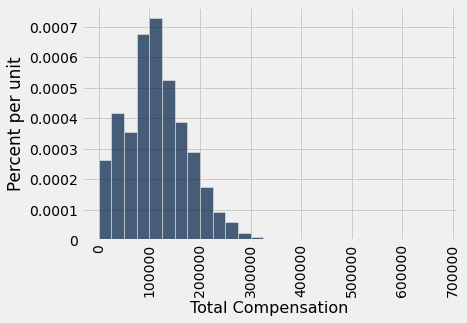

In [8]:
sf_bins = np.arange(0, 700000, 25000)
sf2015.select('Total Compensation').hist(bins=sf_bins)

While most of the values are below \$300,000, a few are quite a bit higher. For example, the total compensation of the Chief Investment Officer was almost \$650,000. That is why the horizontal axis stretches to \$700,000.

In [9]:
sf2015.sort('Total Compensation', descending=True).show(2)

Year Type,Year,Organization Group Code,Organization Group,Department Code,Department,Union Code,Union,Job Family Code,Job Family,Job Code,Job,Employee Identifier,Salaries,Overtime,Other Salaries,Total Salary,Retirement,Health/Dental,Other Benefits,Total Benefits,Total Compensation
Calendar,2015,6,General Administration & Finance,RET,Retirement System,351,Municipal Executive Association - Miscellaneous,1100,Administrative & Mgmt (Unrep),1119,Chief Investment Officer,46881,507832,0,0,507832,105053,12424.5,23566.2,141044,648875
Calendar,2015,6,General Administration & Finance,ADM,General Services Agency - City Admin,164,Physicians and Dentists - Miscellaneous,2500,Med Therapy & Auxiliary,2598,Asst Med Examiner,1016,279311,3829.36,114434,397574,56211.6,12424.5,14299.1,82935.2,480509


Now let the parameter be the median of the total compensations.

Since we have the luxury of having all of the data from the population, we can simply calculate the parameter:

In [10]:
pop_median = percentile(50, sf2015.column('Total Compensation'))
pop_median

110305.79

The median total compensation of all employees was just over \$110,300. 

From a practical perspective, there is no reason for us to draw a sample to estimate this parameter since we simply know its value. But in this section we are going to pretend we don't know the value, and see how well we can estimate it based on a random sample. 

In later sections, we will come down to earth and work in situations where the parameter is unknown. For now, we are all-knowing.

### A Random Sample and an Estimate ###
Let us draw a sample of 500 employees at random without replacement, and let the median total compensation of the sampled employees serve as our estimate of the parameter.

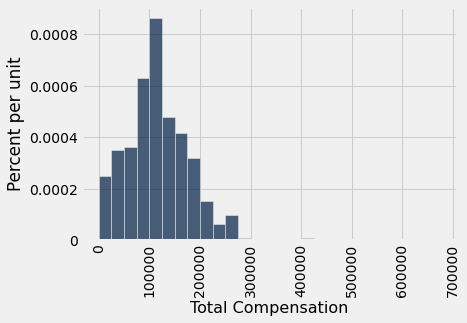

In [11]:
our_sample = sf2015.sample(500, with_replacement=False)
our_sample.select('Total Compensation').hist(bins=sf_bins)

In [12]:
est_median = percentile(50, our_sample.column('Total Compensation'))
est_median

111613.71

The sample size is large. By the law of averages, the distribution of the sample resembles that of the population, and consequently the sample median is not very far from the population median (though of course it is not exactly the same).

So now we have one estimate of the parameter. But had the sample come out differently, the estimate would have had a different value. We would like to be able to quantify the amount by which the estimate could vary across samples. That measure of variability will help us measure how accurately we can estimate the parameter.

To see how different the estimate would be if the sample had come out differently, we could just draw another sample from the population, but that would be cheating. We are trying to mimic real life, in which we won't have all the population data at hand.

Somehow, we have to get another random sample without sampling from the population.

### The Bootstrap: Resampling from the Sample ###
What we do have is a large random sample from the population. As we know, a large random sample is likely to resemble the population from which it is drawn. This observation allows data scientists to *lift themselves up by their own bootstraps*: the sampling procedure can be replicated by *sampling from the sample*. 

Here are the steps of *the bootstrap method* for generating another random sample that resembles the population:

- **Treat the original sample as if it were the population.**
- **Draw from the sample**, at random **with** replacement, **the same number of times as the original sample size**. 

It is important to resample the same number of times as the original sample size. The reason is that the variability of an estimate depends on the size of the sample. Since our original sample consisted of 500 employees, our sample median was based on 500 values. To see how different the sample could have been, we have to compare it to the median of other samples of size 500.

If we drew 500 times at random *without* replacement from our sample of size 500, we would just get the same sample back. By drawing *with* replacement, we create the possibility for the new samples to be different from the original, because some employees might be drawn more than once and others not at all.

Why is this a good idea? By the law of averages, the distribution of the original sample is likely to resemble the population, and the distributions of all the "resamples" are likely to resemble the original sample. So the distributions of all the resamples are likely to resemble the population as well. 

In [13]:

from IPython.display import Image
Image("../../../images/bootstrap_pic.png")

FileNotFoundError: No such file or directory: '../../../images/bootstrap_pic.png'

### A Resampled Median ###
Recall that when the `sample` method is used without specifying a sample size, by default the sample size equals the number of rows of the table from which the sample is drawn. That's perfect for the bootstrap! Here is one new sample drawn from the original sample, and the corresponding sample median.

In [14]:
resample_1 = our_sample.sample()

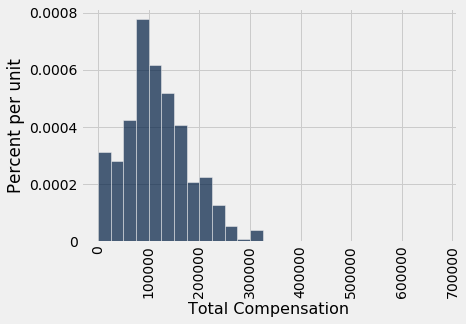

In [15]:
resample_1.select('Total Compensation').hist(bins=sf_bins)

In [16]:
resampled_median_1 = percentile(50, resample_1.column('Total Compensation'))
resampled_median_1

108366.9

By resampling, we have another estimate of the population median. By resampling again and again, we will get many such estimates, and hence an empirical distribution of the estimates.

In [17]:
resample_2 = our_sample.sample()
resampled_median_2 = percentile(50, resample_2.column('Total Compensation'))
resampled_median_2

110391.29

### Bootstrap Empirical Distribution of the Sample Median ###
Let us define a function `bootstrap_median` that takes our original sample, the label of the column containing the variable, and the number of bootstrap samples we want to take, and returns an array of the corresponding resampled medians. 

Each time we resample and find the median, we *replicate* the bootstrap process. So the number of bootstrap samples will be called the number of replications.

In [18]:
def bootstrap_median(original_sample, label, replications):
    """Returns an array of bootstrapped sample medians:
    original_sample: table containing the original sample
    label: label of column containing the variable
    replications: number of bootstrap samples
    """
    just_one_column = original_sample.select(label)
    medians = make_array()
    for i in np.arange(replications):
        bootstrap_sample = just_one_column.sample()
        resampled_median = percentile(50, bootstrap_sample.column(0))
        medians = np.append(medians, resampled_median)
        
    return medians

We now replicate the bootstrap process 5,000 times. The array `bstrap_medians` contains the medians of all 5,000 bootstrap samples. Notice that the code takes longer to run than our previous code. It has a lot of resampling to do!

In [19]:
bstrap_medians = bootstrap_median(our_sample, 'Total Compensation', 5000)

Here is the histogram of the 5000 medians. The red dot is the population parameter: it is the median of the entire population, which we happen to know but did not use in the bootstrap process.

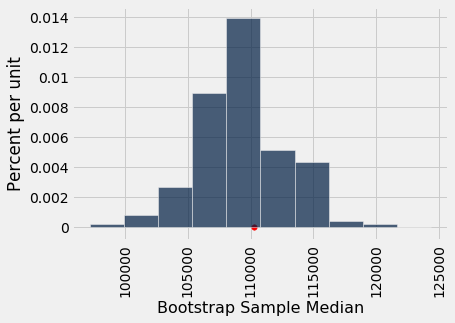

In [20]:
resampled_medians = Table().with_column('Bootstrap Sample Median', bstrap_medians)

#median_bins=np.arange(100000, 130000, 2500)
#resampled_medians.hist(bins = median_bins)
resampled_medians.hist()

plots.scatter(pop_median, 0, color='red', s=30);

It is important to remember that the red dot is fixed: it is \$110,305.79, the population median. The empirical histogram is the result of random draws, and will be situated randomly relative to the red dot. 

Remember also that the point of all these computations is to estimate the population median, which is the red dot. Our estimates are all the randomly generated sampled medians whose histogram you see above. We want those estimates to contain the parameter – it they don't, then they are off.

### Do the Estimates Capture the Parameter? ###

How often does the empirical histogram of the resampled medians sit firmly over the red dot, and not just brush the dot with its tails? To answer this, we must define "sit firmly". Let's take that to mean "the middle 95% of the resampled medians contains the red dot". 

Here are the two ends of the "middle 95%" interval of resampled medians:

In [21]:
left = percentile(2.5, bstrap_medians)
left

102285.4

In [22]:
right = percentile(97.5, bstrap_medians)
right

115557.27

The population median of \$110,305 is between these two numbers. The interval and the population median are shown on the histogram below.

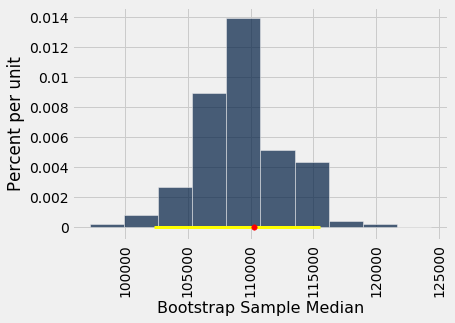

In [23]:
#median_bins=np.arange(100000, 130000, 2500)
#resampled_medians.hist(bins = median_bins)
resampled_medians.hist()

plots.plot(make_array(left, right), make_array(0, 0), color='yellow', lw=3, zorder=1)
plots.scatter(pop_median, 0, color='red', s=30, zorder=2);

The "middle 95%" interval of estimates captured the parameter in our example. But was that a fluke? 

To see how frequently the interval contains the parameter, we have to run the entire process over and over again. Specifically, we will repeat the following process 100 times:

- Draw an original sample of size 500 from the population.
- Carry out 5,000 replications of the bootstrap process and generate the "middle 95%" interval of resampled medians.

We will end up with 100 intervals, and count how many of them contain the population median.

**Spoiler alert:** The statistical theory of the bootstrap says that the number should be around 95. It may be in the low 90s or high 90s, but not much farther off 95 than that.

In [24]:
# THE BIG SIMULATION: This one takes several minutes.

# Generate 100 intervals, in the table intervals

left_ends = make_array()
right_ends = make_array()

total_comps = sf2015.select('Total Compensation')

for i in np.arange(100):
    first_sample = total_comps.sample(500, with_replacement=False)
    medians = bootstrap_median(first_sample, 'Total Compensation', 5000)
    left_ends = np.append(left_ends, percentile(2.5, medians))
    right_ends = np.append(right_ends, percentile(97.5, medians))

intervals = Table().with_columns(
    'Left', left_ends,
    'Right', right_ends
)    

For each of the 100 replications, we get one interval of estimates of the median.

In [25]:
intervals

Left,Right
104850,116807
106560,115858
100109,115978
109391,120038
101859,115358
98604.9,110325
101024,113680
105506,116921
103487,117259
102741,112957


The good intervals are those that contain the parameter we are trying to estimate. Typically the parameter is unknown, but in this section we happen to know what the parameter is.

In [26]:
pop_median

110305.79

How many of the 100 intervals contain the population median? That's the number of intervals where the left end is below the population median and the right end is above.

In [27]:
intervals.where('Left', are.below(pop_median)).where('Right', are.above(pop_median)).num_rows

97

It takes a few minutes to construct all the intervals, but try it again if you have the patience. Most likely, about 95 of the 100 intervals will be good ones: they will contain the parameter.

It's hard to show you all the intervals on the horizontal axis as they have large overlaps – after all, they are all trying to estimate the same parameter. The graphic below shows each interval on the same axes by stacking them vertically. The vertical axis is simply the number of the replication from which the interval was generated.

The red line is where the parameter is. Good intervals cover the parameter; there are about 95 of these, typically. 

If an interval doesn't cover the parameter, it's a dud. The duds are the ones where you can see "daylight" around the red line. There are very few of them – about 5, typically – but they do happen. 

Any method based on sampling has the possibility of being off. The beauty of methods based on random sampling is that we can quantify how often they are likely to be off.

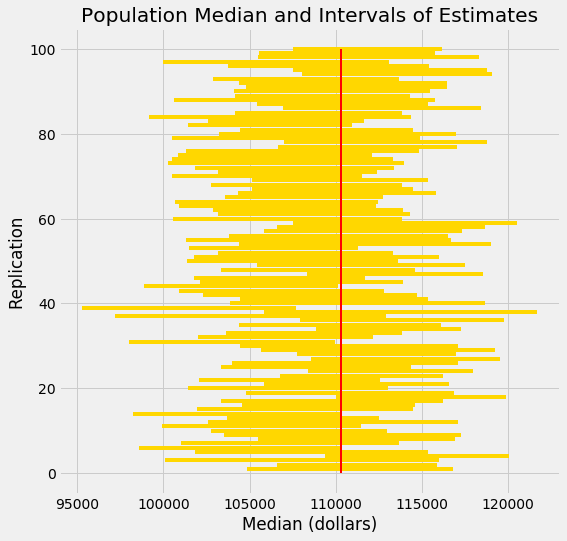

In [28]:
# HIDDEN 

replication_number = np.ndarray.astype(np.arange(1, 101), str)
intervals2 = Table(replication_number).with_rows(make_array(left_ends, right_ends))

plots.figure(figsize=(8,8))
for i in np.arange(100):
    ends = intervals2.column(i)
    plots.plot(ends, make_array(i+1, i+1), color='gold')
plots.plot(make_array(pop_median, pop_median), make_array(0, 100), color='red', lw=2)
plots.xlabel('Median (dollars)')
plots.ylabel('Replication')
plots.title('Population Median and Intervals of Estimates');

To summarize what the simulation shows, suppose you are estimating the population median by the following process: 

- Draw a large random sample from the population.
- Bootstrap your random sample and get an estimate from the new random sample. 
- Repeat the above step thousands of times, and get thousands of estimates.
- Pick off the "middle 95%" interval of all the estimates.

That gives you one interval of estimates. Now if you repeat **the entire process** 100 times, ending up with 100 intervals, then about 95 of those 100 intervals will contain the population parameter.

In other words, this process of estimation captures the parameter about 95% of the time. 

You can replace 95% by a different value, as long as it's not 100. Suppose you replace 95% by 80% and keep the sample size fixed at 500. Then your intervals of estimates will be shorter than those we simulated here, because the "middle 80%" is a smaller range than the "middle 95%". Only about 80% of your intervals will contain the parameter.